In [19]:
## This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [21]:
from PIL import Image

In [22]:
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as T
import torchvision.datasets as datasets
from torch.utils.data import Dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import torchvision.models as models
import os
from tqdm import tqdm

In [23]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


In [24]:
class ConvBlock(nn.Module):
  # helper module that consists of a Conv -> BN -> ReLU
  def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1, with_nonlinearity=True):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, kernel_size=kernel_size, stride=stride)
    self.bn = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU()
    # with_nonlinearity is a boolean flag indicating whether to include the ReLU activation.
    self.with_nonlinearity = with_nonlinearity

  def forward(self, x):
    x = self.conv(x)
    x = self.bn(x)
    if self.with_nonlinearity:
        x = self.relu(x)
    return x

In [25]:
# bridge between the downsampling part with the upsampling part
class Bridge(nn.Module):
    """
    A module serving as a bridge between the downsampling and upsampling parts of a network.
    It consists of two consecutive ConvBlocks.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bridge = nn.Sequential(
          ConvBlock(in_channels, out_channels),
          ConvBlock(out_channels, out_channels)
        )

    def forward(self, x):
        return self.bridge(x)

In [26]:
resnet = torchvision.models.resnet.resnet50(pretrained=True)
list(resnet.children())[4:6]

[Sequential(
   (0): Bottleneck(
     (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (downsample): Sequential(
       (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): Bottleneck(
     (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2):

In [27]:
# (nn.ModuleList(resnet.children()))

In [28]:
down_blocks = []
for layer in resnet.children():
        if isinstance(layer, nn.Sequential):
            down_blocks.extend(bottleneck for bottleneck in layer)

# nn.ModuleList(down_blocks[1:])

In [29]:
class Encoder(nn.Module):
    def __init__(self, in_channels, pretrained=True):
        super(Encoder, self).__init__()
        resnet = torchvision.models.resnet.resnet50(pretrained=True)
        down_blocks = []
        
        self.input_layer = nn.Conv2d(in_channels, 256, kernel_size=7, stride=2, padding=3, bias=False)
        
        for layer in resnet.children():
            if isinstance(layer, nn.Sequential):
                down_blocks.extend(bottleneck.to(device) for bottleneck in layer)
        
        self.down_blocks = down_blocks[1:]  # Getting rid of the first layer
        self.brid = Bridge(2048, 2048).to(device)

    def forward(self, x):
        intermediate_outputs = dict()
        
        x = self.input_layer(x)
        intermediate_outputs['input_layer'] = x.clone()
        
        for i, layer in enumerate(self.down_blocks):
            x = layer(x)
            intermediate_outputs[f"DownLayer{i}"] = x.clone()
        
        x = self.brid(x)
        intermediate_outputs['Post_Bridge'] = x.clone()
        return x, intermediate_outputs

In [30]:
in_channels = 8
height = 256
width = 192
rand = torch.rand(1, in_channels, height, width).to(device)


In [31]:
encoder = Encoder(in_channels).to(device)

In [32]:
output = encoder(rand)
output[0].shape, type(output[1])

(torch.Size([1, 2048, 16, 12]), dict)

In [33]:
for key, value in output[1].items():
    print(f"{key} -- {value.size()}")

input_layer -- torch.Size([1, 256, 128, 96])
DownLayer0 -- torch.Size([1, 256, 128, 96])
DownLayer1 -- torch.Size([1, 256, 128, 96])
DownLayer2 -- torch.Size([1, 512, 64, 48])
DownLayer3 -- torch.Size([1, 512, 64, 48])
DownLayer4 -- torch.Size([1, 512, 64, 48])
DownLayer5 -- torch.Size([1, 512, 64, 48])
DownLayer6 -- torch.Size([1, 1024, 32, 24])
DownLayer7 -- torch.Size([1, 1024, 32, 24])
DownLayer8 -- torch.Size([1, 1024, 32, 24])
DownLayer9 -- torch.Size([1, 1024, 32, 24])
DownLayer10 -- torch.Size([1, 1024, 32, 24])
DownLayer11 -- torch.Size([1, 1024, 32, 24])
DownLayer12 -- torch.Size([1, 2048, 16, 12])
DownLayer13 -- torch.Size([1, 2048, 16, 12])
DownLayer14 -- torch.Size([1, 2048, 16, 12])
Post_Bridge -- torch.Size([1, 2048, 16, 12])


In [34]:
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Decoder, self).__init__()
        
        self.upsample9 = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels=1024, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )

        self.upsample5 = nn.Sequential(
            nn.ConvTranspose2d(1024 + 1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.upsample1 = nn.Sequential(
            nn.ConvTranspose2d(512 + 512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.upsample_fin = nn.ConvTranspose2d(256 + 256, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)

    def forward(self, x, encoder_intermediates):
        x = self.upsample9(x)
        x = torch.cat((x, encoder_intermediates["DownLayer11"]), dim=1)

        x = self.upsample5(x)
        x = torch.cat((x, encoder_intermediates["DownLayer5"]), dim=1)

        x = self.upsample1(x)
        x = torch.cat((x, encoder_intermediates["DownLayer1"]), dim=1)

        x = nn.Sigmoid()(self.upsample_fin(x))
        return x

In [35]:
# # Your tensor
# input_tensor = torch.rand(1, in_channels, height, width)

# # Values to map to
# mapping_values = torch.tensor([0, 1, 5, 6, 7, 8, 9, 10, 11, 12, 13])

# # Manual rounding to the nearest integer from the list
# rounded_tensor = torch.zeros_like(input_tensor, dtype=torch.long)

# for i in range(input_tensor.size(-2)):
#     for j in range(input_tensor.size(-1)):
#         value = input_tensor[0, 0, i, j].item()
#         closest_integer = min(mapping_values, key=lambda x: abs(x - value))
#         rounded_tensor[0, 0, i, j] = closest_integer

# print(rounded_tensor.shape)

In [36]:
decoder = Decoder(2048, 8).to(device)
decoder_out = decoder(output[0], output[1])

In [37]:
decoder_out.size()

torch.Size([1, 8, 256, 192])

In [38]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.encoder = Encoder(in_channels).to(device)
        self.decoder = Decoder(2048, out_channels).to(device) # 2048 channels output from the Encoder

    def forward(self, x):
        # forward pass through the encoder        
        x, encoder_outputs = self.encoder(x)

        # forward pass through the decoder with encoder's intermediate outputs
        decoder_output = self.decoder(x, encoder_outputs)

        
        
        return decoder_output

In [39]:
dummyunet = UNet(8,8).to(device)
rand = torch.rand(1, 8, 256, 192).to(device)
u_out = dummyunet(rand)
u_out.shape

torch.Size([1, 8, 256, 192])

In [40]:
u_out

tensor([[[[0.5139, 0.4318, 0.3233,  ..., 0.2495, 0.5379, 0.3182],
          [0.8070, 0.4389, 0.7149,  ..., 0.3263, 0.7473, 0.5860],
          [0.4230, 0.5156, 0.2746,  ..., 0.2689, 0.1498, 0.2542],
          ...,
          [0.8226, 0.4312, 0.7572,  ..., 0.5473, 0.6180, 0.5563],
          [0.4680, 0.6351, 0.3760,  ..., 0.2085, 0.3934, 0.3620],
          [0.6593, 0.8661, 0.6072,  ..., 0.7196, 0.6482, 0.6020]],

         [[0.4575, 0.5193, 0.5082,  ..., 0.5077, 0.4843, 0.2708],
          [0.3944, 0.6274, 0.4917,  ..., 0.5483, 0.4699, 0.4023],
          [0.4581, 0.7058, 0.3208,  ..., 0.7929, 0.3985, 0.2521],
          ...,
          [0.2267, 0.4516, 0.2720,  ..., 0.4407, 0.4680, 0.5344],
          [0.5396, 0.3653, 0.5857,  ..., 0.5629, 0.5632, 0.3604],
          [0.2168, 0.5297, 0.2013,  ..., 0.5069, 0.4957, 0.6058]],

         [[0.4810, 0.4191, 0.6162,  ..., 0.5832, 0.5773, 0.6175],
          [0.5215, 0.8014, 0.3554,  ..., 0.7526, 0.6098, 0.7730],
          [0.5842, 0.7483, 0.7104,  ..., 0

In [41]:
class Discriminator(nn.Module):
    def __init__(self, input_channels):
        super(Discriminator, self).__init__()
        
        # additional layers to reduce input channels
        self.conv1 = nn.Conv2d(input_channels, 6, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(6)
        self.relu1 = nn.ReLU(inplace=True)
        
        self.conv2= nn.Conv2d(6, 3, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(3)
        self.relu2= nn.ReLU(inplace=True)
        # pre-trained ResNet50
        self.resnet50 = models.resnet50(pretrained=True)
        
        # freeze all layers
        for param in self.resnet50.parameters():
            param.requires_grad = False
            
        # unfreeze layer4 of ResNet50
        for param in self.resnet50.layer4.parameters():
            param.requires_grad = True
        
        # modify the final layer for binary classification
        num_ftrs = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(num_ftrs, 1)
        
        for param in self.resnet50.fc.parameters():
            param.requires_grad = True
        
        # sigmoid activation for binary classification
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        # additional layers
        x = self.conv1(x)
        x=self.bn1(x)
        x = self.relu1(x)
        
        
        x=self.conv2(x)
        x=self.bn2(x)
        x=self.relu2(x)
        
        # forward pass through ResNet50
        x = self.resnet50(x)
                          
        # apply sigmoid activation
        x = self.sigmoid(x)
        
        return x

In [42]:
# resnet50 = models.resnet50(pretrained=True)
# resnet50

In [43]:
# resnet50.fc

In [44]:
def one_hot_encode(labels, class_values):
    """
    Perform one-hot encoding on segmentation labels.

    Args:
        labels (torch.Tensor): Tensor containing label values.
        class_values (list): List of unique class values.

    Returns:
        torch.Tensor: One-hot encoded tensor with channels corresponding to each class.
    """
    one_hot_labels = torch.zeros(len(class_values), *labels.shape[1:])

    for i, class_value in enumerate(class_values):
        one_hot_labels[i] = (labels == class_value).float()

    return one_hot_labels

In [45]:
label_values = [0.0, 1.0, 2.0, 3.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0]

In [46]:
base_dir="/kaggle/input/acgpn-dataset/ACGPN_traindata/train_"

seg_mask_dir="label/"

seg_masks= sorted(os.listdir(base_dir+seg_mask_dir))
seg_masks[:5]

['000003_0.png',
 '000004_0.png',
 '000005_0.png',
 '000006_0.png',
 '000007_0.png']

In [47]:
def openimage(path,mode=0):
    if mode==1:
        return np.expand_dims(np.array(Image.open(path).convert("L")),axis=-1)  # opens in grayscale, we need to open each posemap in b/w
    else:
        return(np.array(Image.open(path)))

In [48]:
img= openimage(base_dir+seg_mask_dir+seg_masks[1],1)
img.shape

(256, 192, 1)

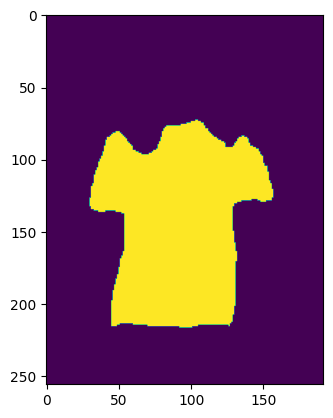

In [49]:
# img[75]
processed_image = np.where(img== 4, 1, 0)
plt.imshow(processed_image)

In [50]:
img= np.array(img)
img.shape

(256, 192, 1)

In [51]:
x= torch.from_numpy(np.random.rand(5))

type(x)

torch.Tensor

In [52]:
class G2Dataset(Dataset):
    def __init__(self, mode, transforms=None):
        super().__init__()
        
        if mode[:2].lower()=="te":
            base_dir="/kaggle/input/acgpn-dataset/ACGPN_testdata/test_"
        else:
            base_dir="/kaggle/input/acgpn-dataset/ACGPN_traindata/train_"
        
        # set directory paths
        
        self.cloth_dir = base_dir+"color/"
        self.img_dir = base_dir+"img/"
        
#         self.fused_dir= base_dir+"fusedmask_Mf/" NOT NEEDED
        
        self.arm_dir= base_dir + "posemaps_arm_rad6/"
        self.face_dir = base_dir+ "posemaps_face_rad3/"
        self.hip_dir = base_dir+ "posemaps_hip_rad8/"
        self.sh_dir = base_dir+ "posemaps_shoulder_line_rad6/"
        
        self.M_w_dir= base_dir+ "mask_Mw/"  
        
        self.clothseg_dir= base_dir+"label/"
#         self.clothseg_dir= base_dir+"edge/"
        # store image names
        self.images= sorted(os.listdir(self.img_dir))
        self.clothes= sorted(os.listdir(self.cloth_dir))
        
#         self.fused= sorted(os.listdir(self.fused_dir)) NOT NEEDED
        
        self.arms= sorted(os.listdir(self.arm_dir))
        self.face= sorted(os.listdir(self.face_dir))
        self.hip= sorted(os.listdir(self.hip_dir))
        self.shoulder= sorted(os.listdir(self.sh_dir))
        
        self.M_w= sorted(os.listdir(self.M_w_dir))
        
        self.clothsegs= sorted(os.listdir(self.clothseg_dir))
        
        self.transforms= transforms
        

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,index):
        def openimage(path,mode=0):
            if mode==1:
                return np.expand_dims(np.array(Image.open(path).convert("L")),axis=-1)  # opens in grayscale, we need to open each posemap in b/w
            else:
                return(np.array(Image.open(path)))

        # stack the posemap together
        face= openimage(os.path.join(self.face_dir, self.face[index]),1)
        arm= openimage(os.path.join(self.arm_dir, self.arms[index]),1)
        shoulder= openimage(os.path.join(self.sh_dir, self.shoulder[index]),1)
        hip= openimage(os.path.join(self.hip_dir, self.hip[index]),1)
        
        posemap= np.dstack([face,shoulder,hip, arm])
        
        #load fused map, cloth image and concatenate w posemap
        M_w= openimage(os.path.join(self.M_w_dir, self.M_w[index]),1)
        M_w= one_hot_encode(torch.from_numpy(M_w.transpose(2,0,1)), label_values) # Mw, loading and one hot encoding, returns tensor 
        
        M_w= M_w.numpy().transpose(1,2,0)*255  # we divide the stacked input by 255 later
        
        cloth= openimage(os.path.join(self.cloth_dir, self.clothes[index]))
        
        final= np.concatenate([M_w,cloth, posemap], axis=2)
        
        #load label, cloth mask in train_edge
        
        label= openimage(os.path.join(self.clothseg_dir, self.clothsegs[index]),1)
        label = np.where(label == 4, 1, 0)

        final_tensor = torch.from_numpy(final.transpose(2, 0, 1)).float()/255
        label_tensor = torch.from_numpy(label.transpose(2, 0, 1)).float()
#         label_tensor = one_hot_encode(label_tensor, label_values)
        
        return final_tensor, label_tensor

In [53]:
tf= T.Compose(
        [
            T.ToTensor(),
        ]
    )

In [54]:
MODE= "TRAIN" # use "TEST" for traning, once ACGPN dataset has all test directories ready
BATCH_SIZE= 8

In [55]:
dataset = G2Dataset(MODE,transforms=tf)

In [56]:
len(dataset)

14221

In [57]:
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=3, pin_memory=True)

In [58]:
len(train_dataloader)

1778

torch.Size([8, 20, 256, 192]) torch.Size([8, 1, 256, 192])


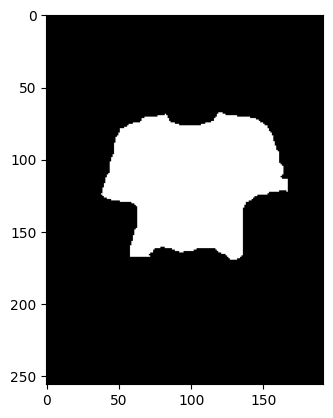

In [59]:
imgs,labels= next(iter(train_dataloader))
print(imgs.shape, labels.shape)
plt.imshow(labels[1][0],cmap="gray")

In [60]:
labels[1][0][100]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

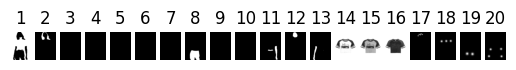

In [61]:
for channel in range(imgs.size(1)):
    plt.subplot(1, 20, channel + 1)
    plt.imshow(imgs[1, channel].cpu(), cmap='gray')
    plt.title(f'{channel + 1}')
    plt.axis('off')
plt.show()

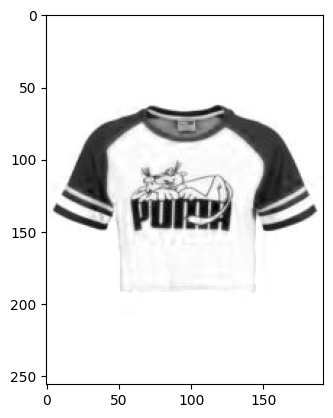

In [62]:
plt.imshow(imgs[1, 13].cpu(), cmap='gray')

In [63]:
# imgs[0][14][50]

In [64]:
# labels[0][0][50]

In [65]:
imgs = imgs.to(device)
labels = labels.to(device)

In [66]:
imgs.shape, labels.shape

(torch.Size([8, 20, 256, 192]), torch.Size([8, 1, 256, 192]))

In [67]:
imgs.device, labels.device

(device(type='cuda', index=0), device(type='cuda', index=0))

#### The segmentation masks M_w and M_w_S have 13 classes

[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [68]:
label_ind_dict = dict()
for i in range(len(label_values)):
    label_ind_dict[i] = label_values[i]
label_ind_dict

{0: 0.0,
 1: 1.0,
 2: 2.0,
 3: 3.0,
 4: 5.0,
 5: 6.0,
 6: 7.0,
 7: 8.0,
 8: 9.0,
 9: 10.0,
 10: 11.0,
 11: 12.0,
 12: 13.0}

In [69]:
imgs.dtype


torch.float32

In [70]:
discrim = Discriminator(20+1).to(device) # 1 for adding cloth segmask
rand = torch.rand(1, 20+1, height, width).to(device)
disout = discrim(rand)
disout.shape

torch.Size([1, 1])

In [71]:
generator = UNet(20, 1).to(device) #20 in_channels and 1 out_channels
discriminator = Discriminator(20+1).to(device) # 1 for adding cloth segmasks


In [72]:
# genout= generator( torch.rand(8,20,256,192).to(device) )
# genout.shape

In [73]:
# plt.imshow(genout[0].cpu().detach().numpy().transpose(1,2,0),cmap='gray')

In [74]:
criterion_bce = nn.BCELoss()
criterion_pixelwise = nn.CrossEntropyLoss()

In [94]:
lr = 0.00002
epochs = 3
lambda1 = 1
lambda2 = 10

In [95]:
optimizer_g = torch.optim.Adam(generator.parameters(), lr=lr, betas = (0.9, 0.999))
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas = (0.9, 0.999))


In [77]:
total_iterations = len(train_dataloader)
generator = generator.to(device)
discriminator = discriminator.to(device)

Epoch 0 | Batch 0 | GenLoss 5.048972129821777 | DiscLoss 0.26178544759750366


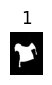

Epoch 0 | Batch 20 | GenLoss 5.6414794921875 | DiscLoss 0.06243439018726349


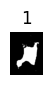

In [ ]:
for epoch in range(epochs):
    for i,data in enumerate(train_dataloader):
        if i>1770:
            break
        inputs,masks=data
        
        # Training discriminator
        
        # Clear discriminator gradients
        optimizer_d.zero_grad()
        
        #send to device
        inputs = inputs.to(device)
        masks=masks.to(device)
        # Pass real images through discriminator
        
        real_preds = discriminator(torch.cat([inputs, masks], dim=1))
        real_targets = torch.ones(inputs.size(0), 1, device=device)
        
        real_loss = criterion_bce(real_preds, real_targets)  #calculate loss for real images

        # Generate fake images
        
#         latent = torch.randn(BATCH_SIZE, latent_size, 1, 1, device=device)
            #lmao latent is now the real_images
        fake_masks = generator(inputs)
        
        # Pass fake images through discriminator
        fake_targets = torch.zeros(fake_masks.size(0), 1, device=device)
        fake_preds = discriminator(torch.cat([inputs, fake_masks], dim=1))
        fake_loss = criterion_bce(fake_preds, fake_targets) #calculate loss for generated images
        
        # Update discriminator weights
        disc_loss = real_loss + fake_loss
        disc_loss.backward()
        optimizer_d.step()      #update disc weights
        
        # Training generator

    
        # Clear generator gradients
        optimizer_g.zero_grad()

        # Generate fake images
        
        #latent = torch.randn(BATCH_SIZE, latent_size, 1, 1, device=device)
        fake_masks = generator(inputs)

        # Try to fool the discriminator
        
        preds = discriminator(torch.cat([inputs, fake_masks], dim=1))
        chinki_loss= torch.nn.functional.cross_entropy(fake_masks, masks, reduction='mean')
        
        targets = torch.ones(BATCH_SIZE, 1, device=device)
        
        gen_loss = criterion_bce(preds, targets) + 10*chinki_loss

        # Update generator weights
        gen_loss.backward()
        
        optimizer_g.step()

        
        
        if i % 20 == 0:
            print(f"Epoch {epoch} | Batch {i} | GenLoss {gen_loss} | DiscLoss {disc_loss}")
            with torch.no_grad():
                # Take one image sample for visualization
                sample_input = inputs[0].unsqueeze(0).to(device)
                sample_fake_masks = generator(sample_input)

            # Visualize all 13 channels separately
            for channel in range(sample_fake_masks.size(1)):
                plt.subplot(1, 13, channel + 1)
                plt.imshow(sample_fake_masks[0, channel].cpu(), cmap='gray')
                plt.title(f'{channel + 1}')
                plt.axis('off')
            plt.show()

In [ ]:
print("6 epochs done")

In [ ]:
test_imgs, test_labels= next(iter(train_dataloader))
test_imgs= test_imgs.to(device)
generated_labels= generator(test_imgs)

In [ ]:
generated_labels.shape, test_labels.shape

In [ ]:
# Assuming test_imgs and generated_labels are already tensors
for img, label in zip(test_labels, generated_labels):
    
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))
  img = img.permute(1, 2, 0).cpu().numpy()  # Move channels to last dim for Matplotlib
  axs[0].imshow(img,cmap="gray")
  
  label = label.permute(1, 2, 0).cpu().detach().numpy()

  axs[0].set_title("Original Image")
  axs[1].imshow(label,cmap="gray")
  axs[1].set_title("Generated Label")
  plt.show()

In [93]:
weights_dir = "/kaggle/working/"
generator_weights_path = os.path.join(weights_dir, 'G2_real_weights1_3epochs.pth')
torch.save(generator.state_dict(), generator_weights_path)
print(f"Generator weights saved to: {generator_weights_path}")

Generator weights saved to: /kaggle/working/G2_real_weights1_3epochs.pth


In [20]:
# from IPython.display import FileLink

# FileLink("G2_weights4.pth")

In [ ]:
# # Assuming 13 channels in the mask
# num_channels = 13

# # Set model to evaluation mode
# generator.eval()
# runtimes = 5000

# # Iterate over the dataset for thresholding
# for inputs, ground_truth_masks in train_dataloader:
#     runtimes -= 1
#     if runtimes == 0:
#         break
#     inputs = inputs.to(device)

#     # Generate fake masks
#     generated_masks = generator(inputs)

#     # Apply thresholding
#     threshold = 0.2
#     generated_masks_binary = (generated_masks > threshold).float()

#     # Visualize original and thresholded masks for one sample
#     with torch.no_grad():
#         sample_input = inputs[0].unsqueeze(0).to(device)
#         sample_generated_masks = generator(sample_input)
#         sample_generated_masks_binary = (sample_generated_masks > threshold).float()

#     plt.figure(figsize=(15, 10))

#     # Display predicted masks
# #     for i in range(num_channels):
# #         plt.subplot(2, num_channels, i + 1)
# #         plt.imshow(sample_generated_masks[0, i].cpu(), cmap='gray')
# #         plt.title(f'P{i + 1}')
# #         plt.axis('off')

#     # Display thresholded masks
#     for i in range(num_channels):
#         plt.subplot(2, num_channels, num_channels + i + 1)
#         plt.imshow(sample_generated_masks_binary[0, i].cpu(), cmap='gray')
#         plt.title(f'T{i + 1}')
#         plt.axis('off')

#     plt.show()

#     # Display ground truth masks
#     plt.figure(figsize=(15, 10))
#     for i in range(num_channels):
#         plt.subplot(1, num_channels, i + 1)
#         plt.imshow(ground_truth_masks[0, i].cpu(), cmap='gray')
#         plt.title(f'G{i + 1}')
#         plt.axis('off')

#     plt.show()

#     print("\n\n")
# # Set model back to training mode
# generator.train()